# Transmissão entre Antenas

![Experimento](transmissao/experimento.jpg)

Nesse experimento verificamos a formação de uma onda estacionária entre antenas transmissora e receptora.

A partir da distância entre picos (ou vales) é possível determinarmos a frequência do sinal transmitido.

In [1]:
# Import necessary modules
import numpy
from matplotlib import pyplot

# Only in Jupyter Notebooks
%matplotlib notebook

Os dados estão armazenados em um arquivo CSV (*comma-separated values*).

Usamos o comando `%cat` (Jupyter Notebook ou terminal IPython) para mostrar o conteúdo de arquivos locais.

In [2]:
%cat transmissao/dados.csv

Distância (mm);Medida 1;Medida 2; Medida 3;Medida 4
280;0.96;0.95;0.96;0.95
281;0.99;1.00;0.98;0.99
282;1.00;0.99;1.00;0.99
283;0.94;0.91;0.95;0.92
284;0.80;0.79;0.81;0.80
285;0.70;0.68;0.69;0.69
286;0.60;0.60;0.62;0.61
287;0.57;0.57;0.57;0.59
288;0.58;0.57;0.56;0.59
289;0.62;0.60;0.60;0.61
290;0.68;0.69;0.68;0.68
291;0.79;0.78;0.78;0.75
292;0.87;0.87;0.86;0.83
293;0.92;0.93;0.92;0.89
294;0.94;0.94;0.94;0.92
295;0.94;0.95;0.94;0.94
296;0.93;0.91;0.93;0.93
297;0.88;0.87;0.88;0.88
298;0.80;0.78;0.79;0.79
299;0.70;0.71;0.70;0.71
300;0.62;0.63;0.62;0.62
301;0.59;0.57;0.57;0.58
302;0.55;0.55;0.55;0.57
303;0.57;0.57;0.56;0.57
304;0.63;0.60;0.61;0.62
305;0.72;0.69;0.68;0.68
306;0.80;0.78;0.77;0.76
307;0.88;0.84;0.86;0.82
308;0.92;0.92;0.92;0.89
309;0.92;0.92;0.92;0.91
310;0.88;0.89;0.89;0.90


É possível ler arquivos em python diretamente, mas teríamos que interpretar e converter os dados manualmente.

```python
data = []
with open('transmissao/dados.csv') as infile:
    print(infile.readline())
    for line in infile:
        data.append([float(i) for i in line.split(';')])
data = numpy.array(data)
```

Contudo o módulo numpy oferece a função `loadtxt` para esse fim.
Além de mais simples, ela é também mais rápida.

In [3]:
numpy.loadtxt?

In [4]:
data = numpy.loadtxt('transmissao/dados.csv', delimiter=';', skiprows=1)
data

array([[ 280.  ,    0.96,    0.95,    0.96,    0.95],
       [ 281.  ,    0.99,    1.  ,    0.98,    0.99],
       [ 282.  ,    1.  ,    0.99,    1.  ,    0.99],
       [ 283.  ,    0.94,    0.91,    0.95,    0.92],
       [ 284.  ,    0.8 ,    0.79,    0.81,    0.8 ],
       [ 285.  ,    0.7 ,    0.68,    0.69,    0.69],
       [ 286.  ,    0.6 ,    0.6 ,    0.62,    0.61],
       [ 287.  ,    0.57,    0.57,    0.57,    0.59],
       [ 288.  ,    0.58,    0.57,    0.56,    0.59],
       [ 289.  ,    0.62,    0.6 ,    0.6 ,    0.61],
       [ 290.  ,    0.68,    0.69,    0.68,    0.68],
       [ 291.  ,    0.79,    0.78,    0.78,    0.75],
       [ 292.  ,    0.87,    0.87,    0.86,    0.83],
       [ 293.  ,    0.92,    0.93,    0.92,    0.89],
       [ 294.  ,    0.94,    0.94,    0.94,    0.92],
       [ 295.  ,    0.94,    0.95,    0.94,    0.94],
       [ 296.  ,    0.93,    0.91,    0.93,    0.93],
       [ 297.  ,    0.88,    0.87,    0.88,    0.88],
       [ 298.  ,    0.8 ,   

In [5]:
data.shape

(31, 5)

In [6]:
data[0, :]

array([ 280.  ,    0.96,    0.95,    0.96,    0.95])

In [7]:
data[0, :].shape

(5,)

Separamos os valores de distância da 1ª coluna no vetor `x` e as medidas em `v`:

In [13]:
x = data[:, 0]
x

array([ 280.,  281.,  282.,  283.,  284.,  285.,  286.,  287.,  288.,
        289.,  290.,  291.,  292.,  293.,  294.,  295.,  296.,  297.,
        298.,  299.,  300.,  301.,  302.,  303.,  304.,  305.,  306.,
        307.,  308.,  309.,  310.])

In [14]:
v = data[:, 1:]
v

array([[ 0.96,  0.95,  0.96,  0.95],
       [ 0.99,  1.  ,  0.98,  0.99],
       [ 1.  ,  0.99,  1.  ,  0.99],
       [ 0.94,  0.91,  0.95,  0.92],
       [ 0.8 ,  0.79,  0.81,  0.8 ],
       [ 0.7 ,  0.68,  0.69,  0.69],
       [ 0.6 ,  0.6 ,  0.62,  0.61],
       [ 0.57,  0.57,  0.57,  0.59],
       [ 0.58,  0.57,  0.56,  0.59],
       [ 0.62,  0.6 ,  0.6 ,  0.61],
       [ 0.68,  0.69,  0.68,  0.68],
       [ 0.79,  0.78,  0.78,  0.75],
       [ 0.87,  0.87,  0.86,  0.83],
       [ 0.92,  0.93,  0.92,  0.89],
       [ 0.94,  0.94,  0.94,  0.92],
       [ 0.94,  0.95,  0.94,  0.94],
       [ 0.93,  0.91,  0.93,  0.93],
       [ 0.88,  0.87,  0.88,  0.88],
       [ 0.8 ,  0.78,  0.79,  0.79],
       [ 0.7 ,  0.71,  0.7 ,  0.71],
       [ 0.62,  0.63,  0.62,  0.62],
       [ 0.59,  0.57,  0.57,  0.58],
       [ 0.55,  0.55,  0.55,  0.57],
       [ 0.57,  0.57,  0.56,  0.57],
       [ 0.63,  0.6 ,  0.61,  0.62],
       [ 0.72,  0.69,  0.68,  0.68],
       [ 0.8 ,  0.78,  0.77,  0.76],
 

<IPython.core.display.Javascript object>


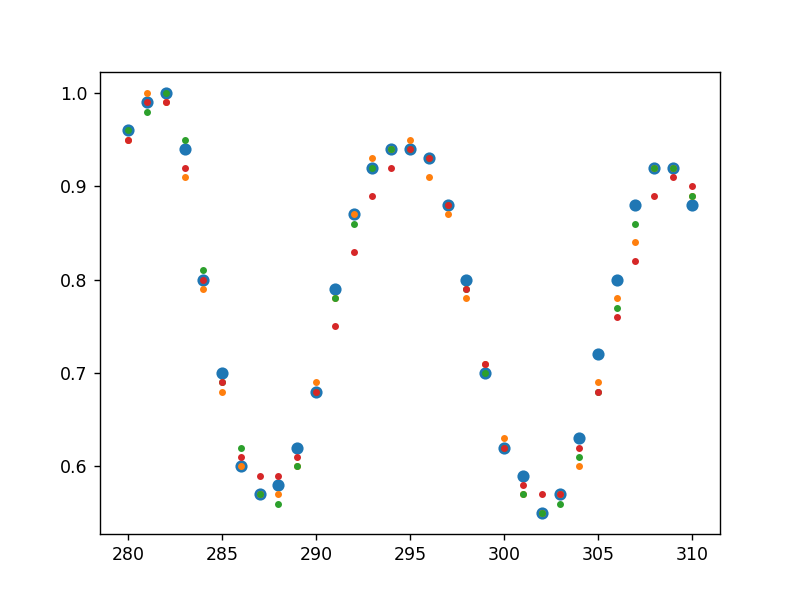

In [16]:
fig, ax = pyplot.subplots(1, 1)

ax.plot(x, v[:, 0], 'o')
ax.plot(x, v[:, 1], '.')
ax.plot(x, v[:, 2], '.')
ax.plot(x, v[:, 3], '.')

Podemos analisar os dados em termos de médias e desvios padrão:

In [18]:
v0 = v[0, :]
print(v0, numpy.mean(v0), numpy.std(v0))

[ 0.96  0.95  0.96  0.95] 0.955 0.005


In [19]:
%%timeit
y = numpy.zeros(len(x))
for i in range(len(x)):
    y[i] = numpy.mean(v[i, :])

1000 loops, best of 3: 229 µs per loop


In [20]:
%%timeit
y = numpy.mean(v, axis=1)

The slowest run took 9.64 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 9.53 µs per loop


In [34]:
y = numpy.mean(v, axis=1)
e = numpy.std(v, axis=1)
y

array([ 0.955 ,  0.99  ,  0.995 ,  0.93  ,  0.8   ,  0.69  ,  0.6075,
        0.575 ,  0.575 ,  0.6075,  0.6825,  0.775 ,  0.8575,  0.915 ,
        0.935 ,  0.9425,  0.925 ,  0.8775,  0.79  ,  0.705 ,  0.6225,
        0.5775,  0.555 ,  0.5675,  0.615 ,  0.6925,  0.7775,  0.85  ,
        0.9125,  0.9175,  0.89  ])

<IPython.core.display.Javascript object>


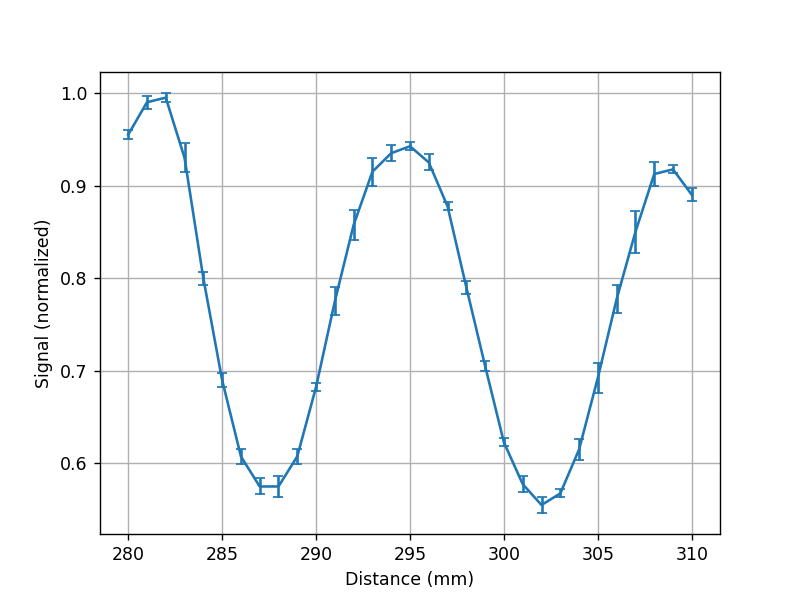

In [37]:
fig, ax = pyplot.subplots(1, 1)

ax.errorbar(x, y, e, capsize=3)

ax.set_xlabel('Distance (mm)')
ax.set_ylabel('Signal (normalized)')

ax.grid()

Há mais de uma maneira de buscar a distância entre máximos.
Simplesmente olhar para o gráfico é uma delas, mas imagine que temos centenas ou milhares desses conjuntos de dados.
Nesse caso é melhor buscarmos um método mais automático de análise.

Devido ao ruído, usar simplesmente `numpy.max` pode resultar em baixa precisão.

Outra opção é usar algum tipo de filtragem (o módulo `scipy.signal` possui diversas opções de filtros), mas também funcionaria melhor se tivéssemos maior densidade de pontos.

Para os dados disponíveis, podemos usar o fato de que o sinal é quase senoidal e usar a transformada discreta de Fourier para determinar o coeficiente de maior magnitude (excluindo a frequência 0).

In [38]:
numpy.fft.rfft(y)

array([  2.41075000e+01 +0.00000000e+00j,
         5.87844334e-01 -2.83104022e-01j,
         2.96932787e+00 +6.33910146e-01j,
        -3.30978176e-01 -4.80990019e-01j,
        -3.10613975e-01 -3.45420446e-01j,
        -1.62236055e-01 -1.46955339e-01j,
        -1.41777252e-01 -1.72088261e-01j,
        -6.91280115e-02 -1.07743322e-02j,
        -1.68979415e-02 -4.84622172e-02j,
         1.39133982e-02 -3.86695941e-02j,
         3.44004292e-02 -3.76600492e-02j,
         4.23835988e-02 -6.85983074e-03j,
         5.22334657e-02 -1.71263089e-02j,
         4.59114994e-02 -1.60656852e-02j,
         1.53319291e-02 +4.24995060e-04j,   1.90348828e-02 -2.20421970e-02j])

<IPython.core.display.Javascript object>


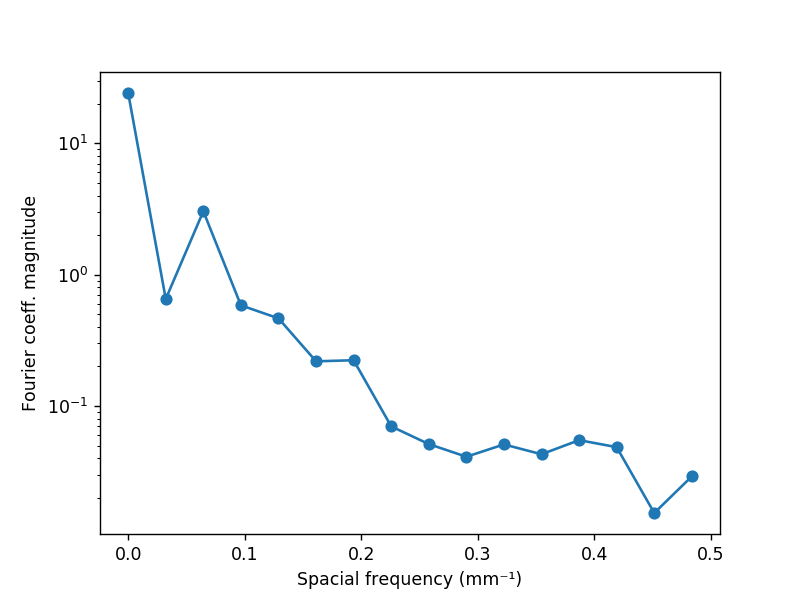

In [56]:
c = numpy.abs(numpy.fft.rfft(y))
k = numpy.fft.rfftfreq(len(y), x[1] - x[0])

fig, ax = pyplot.subplots(1, 1)

ax.semilogy(k, c, 'o-')

ax.set_xlabel('Spacial frequency (mm⁻¹)')
ax.set_ylabel('Fourier coeff. magnitude')

In [49]:
numpy.max(c[1:])

3.0362394660113741

In [52]:
numpy.argmax(c)

2

In [46]:
c[1]

0.65246367537422212

In [53]:
i = numpy.argmax(c)
i

2

In [54]:
c[i]

3.0362394660113634

In [ ]:
ax.annotate?

<IPython.core.display.Javascript object>


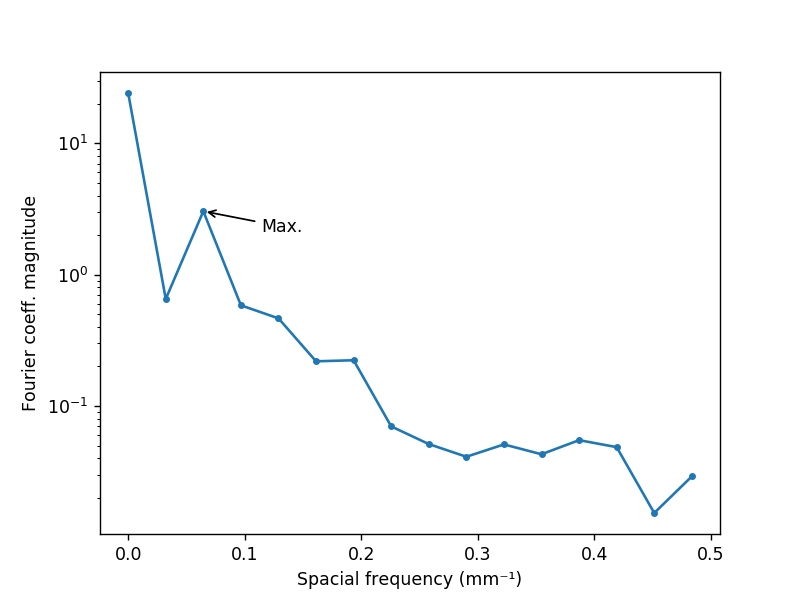

Frequency: (9.7 ± 4.8) GHz


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide


In [57]:
fig, ax = pyplot.subplots(1, 1)

ax.semilogy(k, c, '.-')
ax.annotate(xy=(k[i], c[i]), s='Max.',
            xytext=(k[i] + 0.05, c[i] * 0.7),
            arrowprops={'arrowstyle': '->'})

ax.set_xlabel('Spacial frequency (mm⁻¹)')
ax.set_ylabel('Fourier coeff. magnitude')

lda = 2 / k
f = 3e8 / (lda * 1e-3)
print('Frequency: ({:.1f} ± {:.1f}) GHz'.format(f[i]*1e-9, (f[i+1] - f[i-1]) / 2e9))

Aqui também a esparcidade de dados limita a precisão.

A solução neste caso é usar nosso conhecimento do experimento: sabemos que uma onda estacionária tem distribuição espacial de potência senoidal.
Portanto, podemos ajustar um modelo aos dados e assim determinar a frequência da melhor senoide que reproduz os dados coletados (similarmente ao que fizemos com o ajuste linear usando `numpy.polyfit`).

In [58]:
from scipy.optimize import curve_fit

curve_fit?

Nosso modelo deve ser uma função da posição e dos parâmetros que queremos otimizar.
Por se tratar de um problema não-linear, é preciso dar um chute inicial razoável para o algoritmo de ajuste.

In [76]:
def model(x, k, a, x0, y0):
    return y0 + a * numpy.sin(2*numpy.pi*k*(x - x0))

model(0.25, 0.2, 2, 0, 0)

0.61803398874989479

In [60]:
x_fit = numpy.array([0, 0.25, 0.5, 0.75, 1])
model(x_fit, 0.1, 1, 0, 0)

array([ 0.        ,  0.15643447,  0.30901699,  0.4539905 ,  0.58778525])

In [66]:
args = [0.1, 1, 0, 0]
model(x_fit, *args)

array([ 0.        ,  0.15643447,  0.30901699,  0.4539905 ,  0.58778525])

<IPython.core.display.Javascript object>


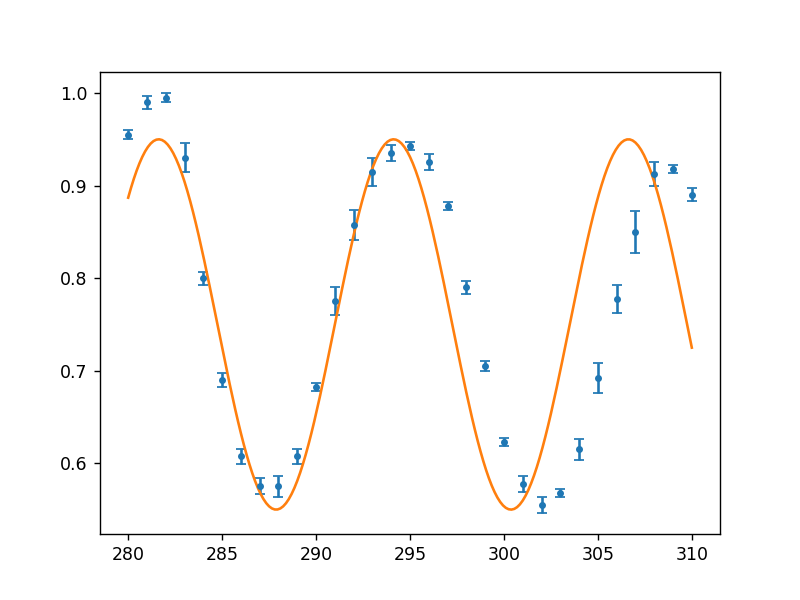

In [70]:
init = (0.08, 0.2, 291, 0.75)

x_fit = numpy.linspace(x[0], x[-1], 201)

y_init = model(x_fit, *init)

fig, ax = pyplot.subplots(1, 1)

ax.errorbar(x, y, e, capsize=3, ls='', marker='.')
ax.plot(x_fit, y_init)

In [78]:
opt, cov = curve_fit(model, x, y, init)

print(opt)
print(numpy.sqrt(numpy.diag(cov)))

[  7.04160938e-02   1.97948314e-01   2.91353659e+02   7.61859037e-01]
[ 0.00081763  0.00745233  0.09986942  0.00572152]


<IPython.core.display.Javascript object>


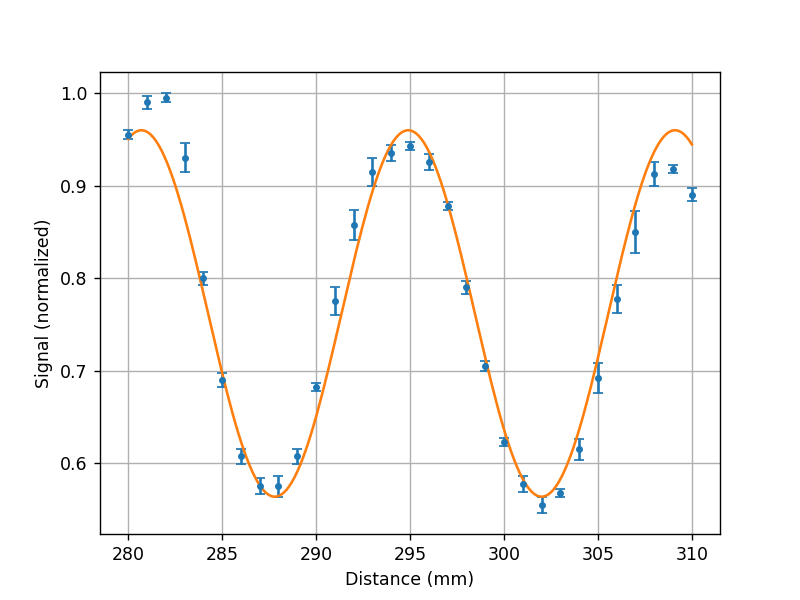

In [79]:
y_fit = model(x_fit, *opt)

fig, ax = pyplot.subplots(1, 1)

ax.errorbar(x, y, e, capsize=3, ls='', marker='.')
ax.plot(x_fit, y_fit)

ax.set_xlabel('Distance (mm)')
ax.set_ylabel('Signal (normalized)')

ax.grid()

Conhecendo o modelo, sabemos qua a distância entre máximos é a metade do comprimento de onda do sinal transmitido.

In [80]:
lda = 2 / opt[0]
f = 3e8 / (lda * 1e-3)
print('Frequency: {:.1f} GHz'.format(f*1e-9))

Frequency: 10.6 GHz


## Exercício

Modifique o modelo para usar diretamente a frequência do sinal, possibilitando a determinação da confiabilidade desse parâmetro diretamente da matriz de covariância.

<IPython.core.display.Javascript object>


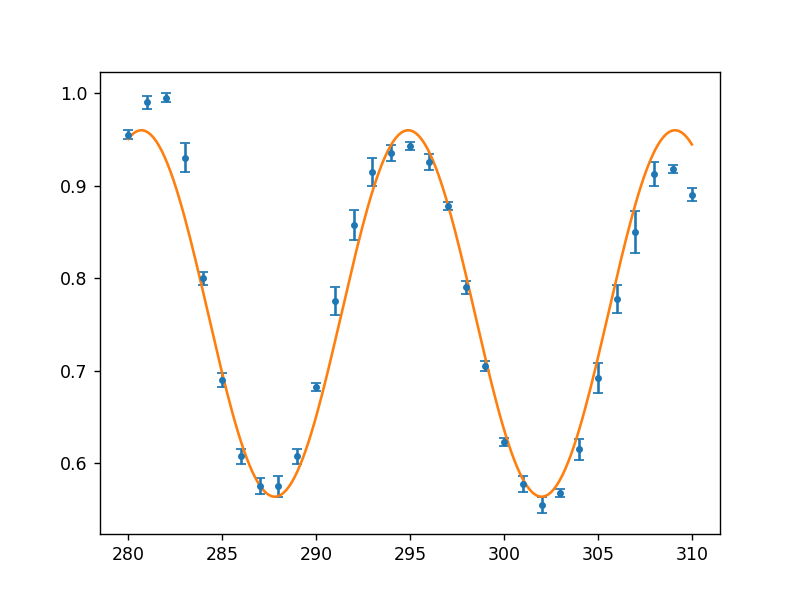

10.5624033962 0.122644613042


In [88]:
def model2(x, f, a, x0, y0):
    lda = 1e3 * 3e8 / (f * 1e9)
    k = 2 / lda
    return y0 + a * numpy.sin(2*numpy.pi*k*(x - x0))

init = (10.0, 0.2, 291, 0.75)

x_fit = numpy.linspace(x[0], x[-1], 201)

opt, cov = curve_fit(model2, x, y, init)

y_fit = model2(x_fit, *opt)

fig, ax = pyplot.subplots(1, 1)

ax.errorbar(x, y, e, capsize=3, ls='', marker='.')
ax.plot(x_fit, y_fit)

print(opt[0], numpy.sqrt(cov[0, 0]))

Podemos usar um modelo mais físico para resolver o problema:

<IPython.core.display.Javascript object>


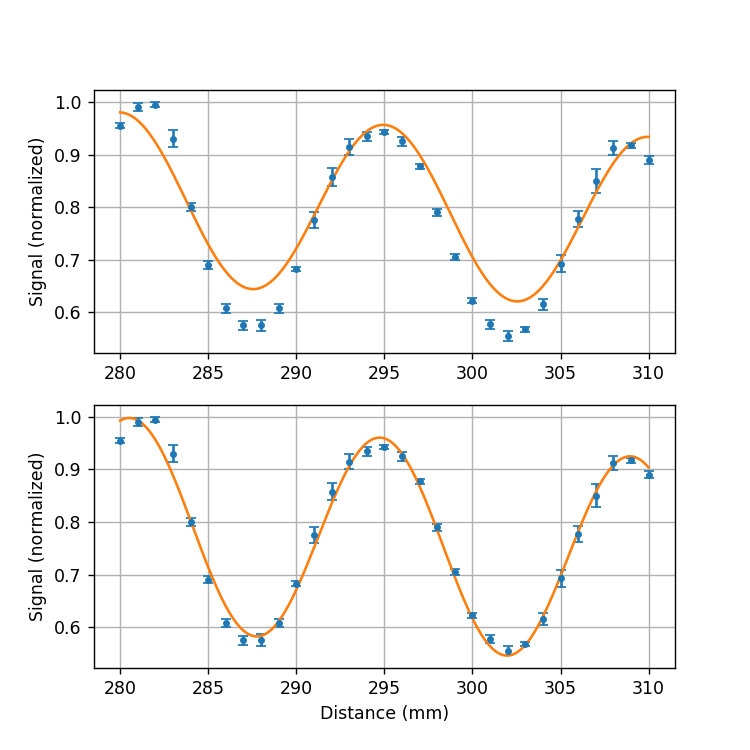

Frequency: (10.55 ± 0.08) GHz


In [91]:
def model3(x, f, a, e0, g, p0, p1):
    phi = (a + 6.67e-3j * numpy.pi * f) * (x - 280)
    y = e0 * (numpy.exp(1j * p0 - phi) + g * numpy.exp(1j * p1 + phi))
    return numpy.abs(y)**2

init2 = (10, 0.001, 0.9, 0.1, 0, 0)
opt2, cov2 = curve_fit(model3, x, y, init)

y_init = model3(x_fit, *init2)
y_fit = model3(x_fit, *opt2)

fig, ax = pyplot.subplots(2, 1, figsize=(6, 6))

for a in ax:
    a.errorbar(x, y, e, capsize=3, ls='', marker='.')
    a.set_ylabel('Signal (normalized)')
    a.grid()
ax[1].set_xlabel('Distance (mm)')

ax[0].plot(x_fit, y_init)
ax[1].plot(x_fit, y_fit)

print('Frequency: ({:.2f} ± {:.2f}) GHz'.format(opt[0], cov[0, 0]**0.5))

In [93]:
a = numpy.matrix([[1,2],[3,4]])
a

matrix([[1, 2],
        [3, 4]])

In [94]:
a.I

matrix([[-2. ,  1. ],
        [ 1.5, -0.5]])

In [95]:
a.I * a

matrix([[  1.00000000e+00,   0.00000000e+00],
        [  1.11022302e-16,   1.00000000e+00]])